In [49]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from textblob import TextBlob

import pandas as pd
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

In [2]:
df = pd.read_csv("Tui_TrustPilot.csv")
df.drop("Unnamed: 0", axis = 1, inplace = True)

# Topic Modelling

## Lemmtization

In [3]:
#delete the that
stop_words = set(stopwords.words('english'))
'that' in stop_words

True

In [6]:
body_ = []
exc_list = string.punctuation + string.digits + "’"
stop_words = set(stopwords.words('english'))

def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

for x in range(0, len(df.Body)):
    rev = df.Body[x]
    rev = rev.lower()
    rev = rev.translate(str.maketrans("","", exc_list))
    rev = rev.replace("\n", " ")

    rev_list = []

    for word in word_tokenize(rev):
        if word not in stop_words:
            rev_list.append(word)
    
    rev_sentence = " ".join(rev_list)

    body_.append(lemmatize_with_postag(rev_sentence))


df.Body = body_

## Wordclouds

In [8]:
def get_topics(components, feature_names, n=50):
    for idx, topic in enumerate(components):
        print("\nTopic %d: " % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])
        
vectorizer = TfidfVectorizer(max_features=1000) 
X = vectorizer.fit_transform(df.Body)

nmf_model = NMF(n_components=3, init='random', random_state=0)
nmf_top = nmf_model.fit_transform(X)

terms = vectorizer.get_feature_names() #get_feature_names_out in future versions
get_topics(nmf_model.components_, terms)


Topic 1:  [('refund', 1.45), ('cancel', 0.7), ('day', 0.61), ('holiday', 0.59), ('receive', 0.52), ('tui', 0.46), ('money', 0.45), ('email', 0.44), ('still', 0.42), ('week', 0.41), ('credit', 0.38), ('th', 0.38), ('within', 0.35), ('full', 0.34), ('get', 0.34), ('wait', 0.31), ('due', 0.3), ('month', 0.3), ('account', 0.3), ('bank', 0.29), ('back', 0.27), ('would', 0.26), ('card', 0.23), ('request', 0.22), ('say', 0.21), ('may', 0.21), ('july', 0.21), ('later', 0.21), ('process', 0.21), ('pay', 0.2), ('take', 0.19), ('book', 0.17), ('august', 0.15), ('june', 0.15), ('ago', 0.15), ('tell', 0.15), ('company', 0.15), ('contact', 0.15), ('use', 0.14), ('claim', 0.14), ('code', 0.14), ('go', 0.14), ('cruise', 0.13), ('today', 0.13), ('covid', 0.12), ('give', 0.12), ('payment', 0.12), ('court', 0.12), ('another', 0.12), ('promise', 0.11)]

Topic 2:  [('tui', 0.68), ('holiday', 0.68), ('book', 0.59), ('flight', 0.44), ('change', 0.39), ('hotel', 0.37), ('go', 0.37), ('year', 0.36), ('travel'

In [27]:
for idx, topic in enumerate(nmf_model.components_):
    if idx == 2: #change topic numbers
        topic_x = [(terms[i], topic[i].round(2)) for i in topic.argsort()[:-1000 - 1:-1]]
        topic_x = {i[0]:i[1] for i in topic_x}
            
        wordcloud = WordCloud(width = 3000, height = 3000, stopwords=STOPWORDS, background_color="white", min_font_size = 30)
        wordcloud = wordcloud.generate_from_frequencies(topic_x)
        wordcloud.to_file("WordClouds//Topic_{}.png".format(idx+1))

# Word Frequency

In [40]:
def word_counter(data):
    from collections import Counter

    freq_lst = []
    
    for i in range(len(data)):
        words = word_tokenize(data[i])
        
        for word in words:
            freq_lst.append(word)
    
    word_freq = Counter(freq_lst)

    df_wf = {
        'Word' : word_freq.keys(),
        'Count' : word_freq.values()
    }
    
    df_wf = pd.DataFrame(df_wf)
    df_wf.sort_values(by = "Count", axis = 0, ignore_index = True, inplace= True, ascending= False)

    return df_wf

In [41]:
df_wf = word_counter(df.Body)

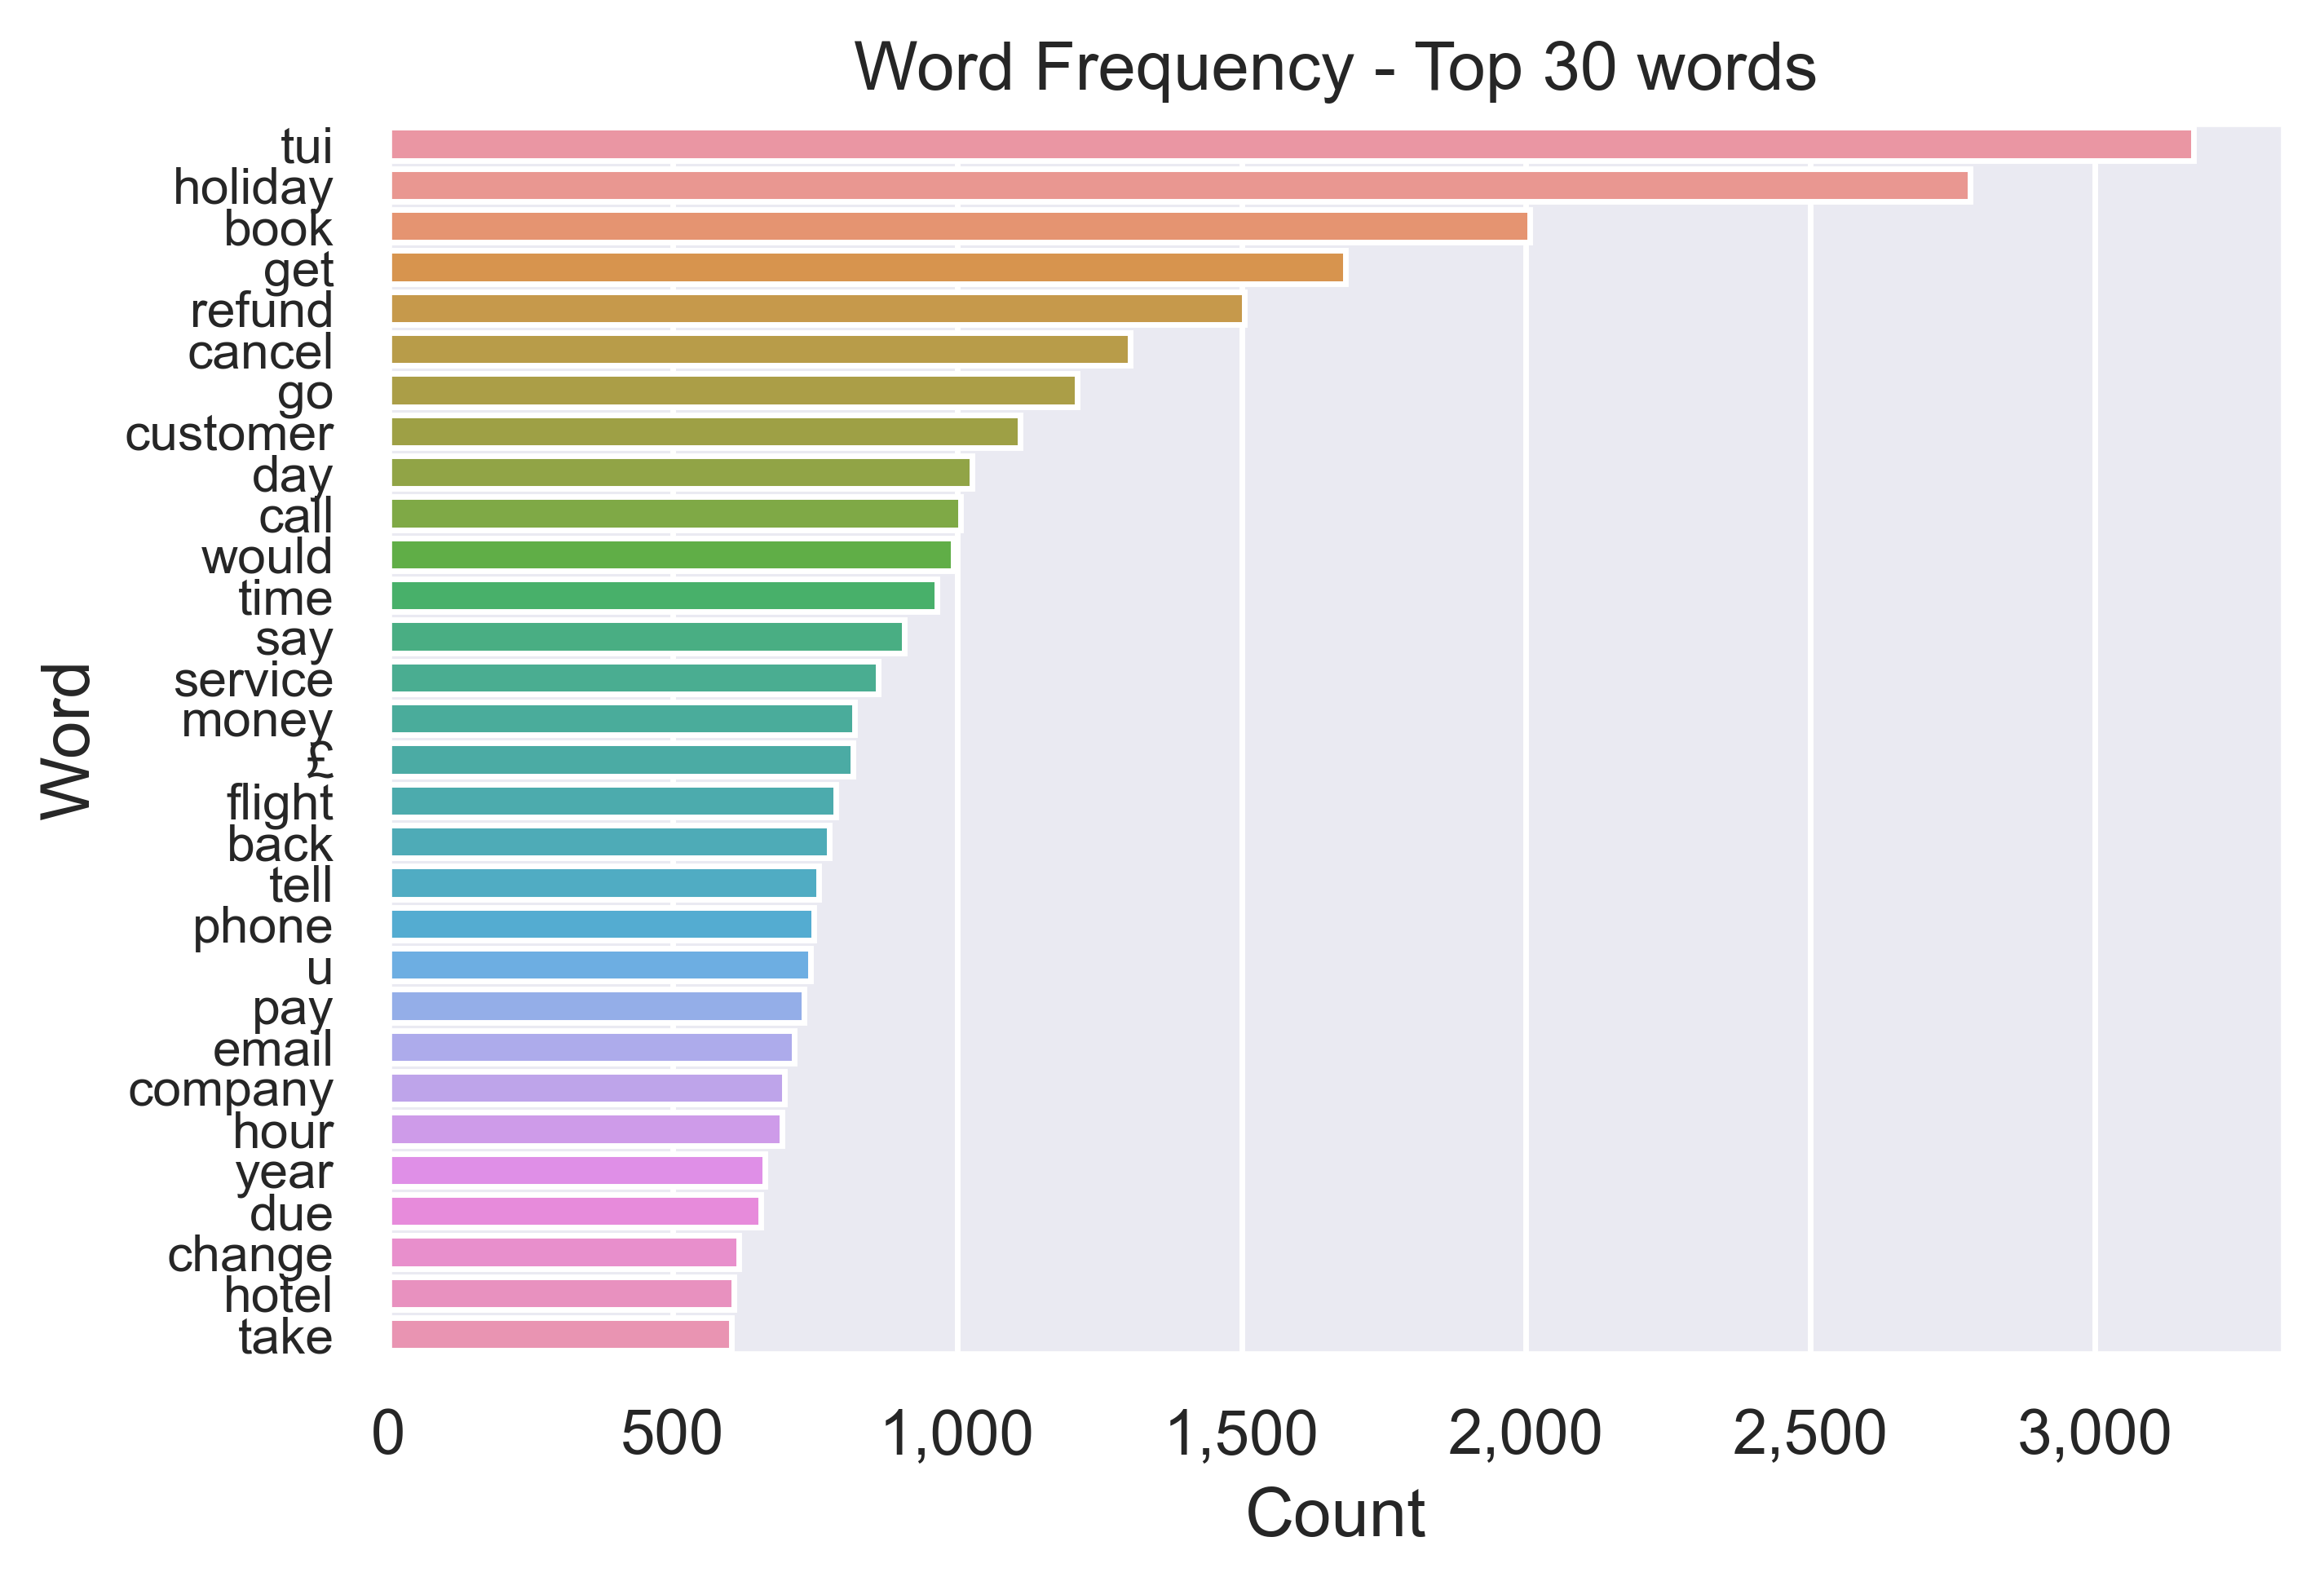

In [67]:
sns.set_theme()
fig, ax = plt.subplots(1, 1, dpi = 500)

sns.barplot(
    data = df_wf.head(30), 
    x = "Count", 
    y = "Word", 
    ax = ax
)
plt.title("Word Frequency - Top 30 words")

ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis= 'y', which = 'major', labelsize = 9)

# Basic Info

In [89]:
days_ = str(max(pd.to_datetime(df.Date)) - min(pd.to_datetime(df.Date))).split(" ")[0]
print(f"""
Data Range:\t{min(df.Date)} - {max(df.Date)}, which equals to {days_} days
Data Set Length:\t{len(df)}
""")



Data Range:	2020-07-06 - 2021-11-03, which equals to 485 days
Data Set Length:	1999



In [95]:
location = df.Location.value_counts()

In [122]:
loc_dic = {
    "GB" : location["GB"],
    "US" : location["US"],
    "ES" : location["ES"],
    "Others" : location[location < 10].sum()
    }

location = pd.Series(data = loc_dic, index = loc_dic.keys())

Text(0.5, 1.0, 'Reviewer Nationality')

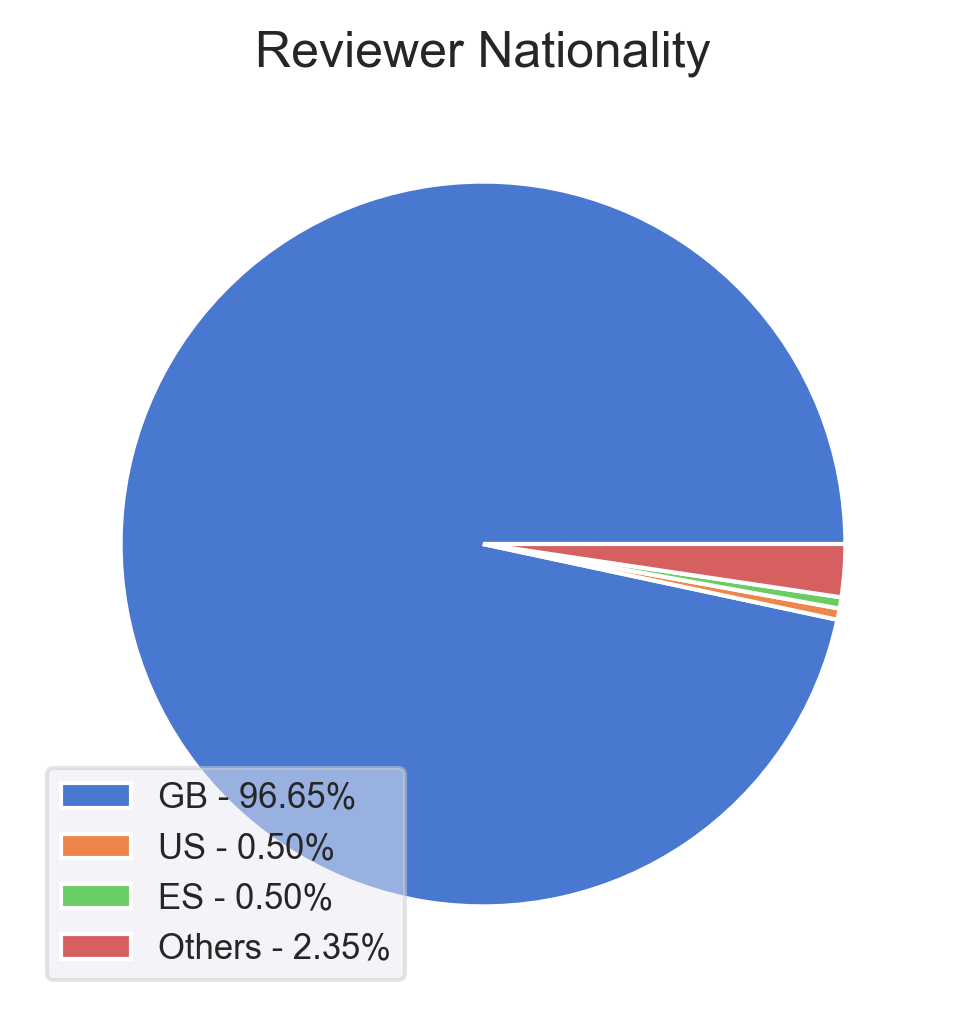

In [206]:
def get_values(series : pd.Series):
    try:
        labels = []
        
        sum_ = sum(series)
        for i in series.index:
            pct_ = series[i] / sum_
            label = "{} - {:.2%}".format(i, pct_)
            labels.append(label)
        
        return labels
    except TypeError:
        print("Wrong Input, must be pd.Series")

fig, ax = plt.subplots(1, 1, dpi = 300)

colors = sns.color_palette("muted")[:4]
ax.pie(location, colors = colors)
plt.legend(loc = 3, labels = get_values(location), fontsize = 'x-small', framealpha = 0.5)
plt.title("Reviewer Nationality")